In [114]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Funciones para generar estados latentes

In [115]:
# Generate conectivity matrices of S states
import random as rn
import numpy as np
# adapted from gen_A in BalloonModelNet
def gen_A(N_nds=5, N_conn=3, seed = None, sym=False):
    A = np.eye(N_nds)
    node_pairs = []
    for i in range(N_nds):
        for j in range(N_nds):
            if i > j:
                node_pairs.append( (i,j) )

    rn.seed(seed)
    nodes_connected = []
    while len(nodes_connected)<N_conn:
        n = rn.choice( node_pairs )
        if n not in nodes_connected:
            nodes_connected.append( n )
    for i, j in nodes_connected:
        A[i, j] = rn.choice(np.arange(0.50,0.90,0.01))

    if sym: # sym is True, the matrix is symetric
        A = A + A.T - np.diag(A.diagonal())

    return A

# Generate conectivity matrices for each state
def gen_states_A(S, D, N_conns, sym=False, seed=None):
    As = []
    for i in range(S):
        if seed == None:
            A = gen_A(N_nds=D, N_conn=N_conns[i], seed=seed, sym=sym)
        else:
            A = gen_A(N_nds=D, N_conn=N_conns[i], seed=seed, sym=sym)
            seed += 5
        As.append(A)
    #print(As)
    return np.array(As)

# 1. Modelo Balloon y sus señales

### 1.1 Actividad neuronal

(598,)


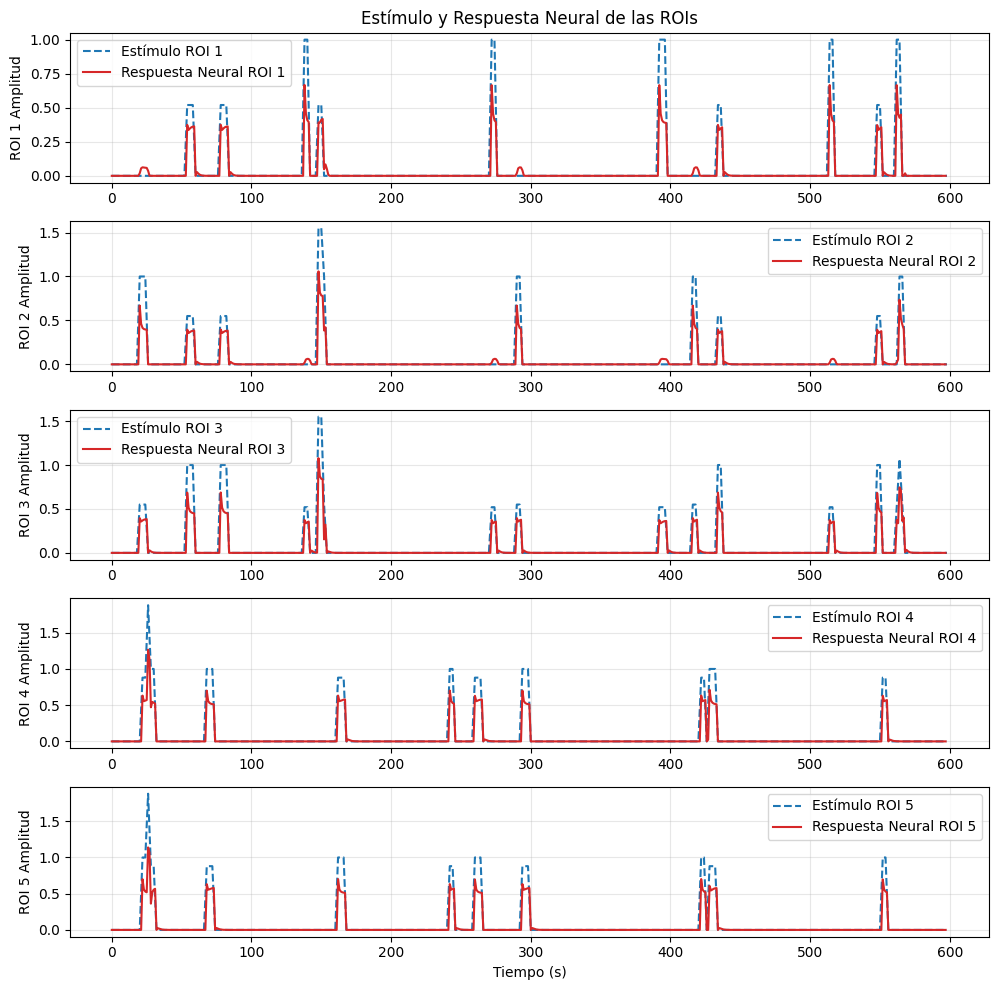

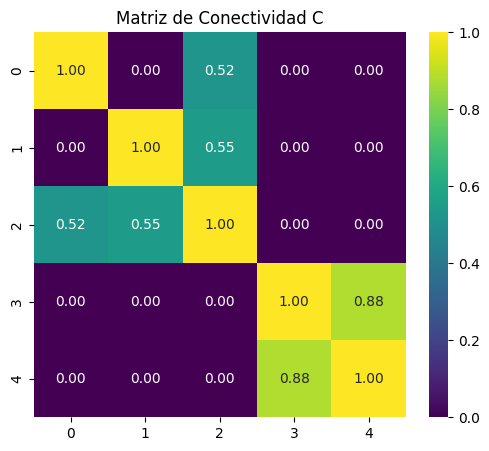

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from scipy.interpolate import interp1d
import sys
import seaborn as sns

module_name = "BalloonModelNet"
file_path = "/content/drive/MyDrive/Balloon_model/BalloonModelNet.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
bmn = importlib.util.module_from_spec(spec)
sys.modules[module_name] = bmn
spec.loader.exec_module(bmn)

# Parameters
TR = 2         # Repetition Time
T = 300    # temporal points
D = 5            # number of ROIs
block_len = 10   # duración promedio de bloque
on_prob = 0.1    # probabilidad de "encender" un bloque
const = 1.0      # scale factor
#C = np.zeros((D, D))  # Sin acoplamiento entre ROIs
C = gen_states_A(S=1, D=D, N_conns=[3], sym=True, seed=None)[0]
#np.fill_diagonal(C, 0.0)
# Generar estímulo
#U = gen_stimuli(T, D, kind="blocks", block_len=block_len, on_prob=on_prob)
timeline = TR*np.arange(T)

U = bmn.gen_network_stimulus(timeline, N_nds=D, nblocks=5, duration_range=(2, 3))#(1,3)

u = np.transpose(C @ U.T)

# Simular respuesta neural
t_neur, neur = bmn.StimulusToNeural(timeline, u, const, C)

num_rois = neur.shape[1]
plt.figure(figsize=(10, num_rois * 2)) # Adjust figure size based on the number of ROIs

for i in range(num_rois):
    plt.subplot(num_rois, 1, i + 1)
    plt.plot(timeline, u[:, i], label=f"Estímulo ROI {i+1}", color='tab:blue', linewidth=1.5, linestyle='--')
    plt.plot(t_neur, neur[:, i], label=f"Respuesta Neural ROI {i+1}", color='tab:red', linewidth=1.5)
    plt.ylabel(f"ROI {i+1} Amplitud")
    plt.grid(alpha=0.3)
    if i == 0:
        plt.title("Estímulo y Respuesta Neural de las ROIs")
    if i == num_rois - 1:
        plt.xlabel("Tiempo (s)")
    plt.legend()

plt.tight_layout()
plt.show()

# show conectivity matrix
plt.figure(figsize=(6, 5))
sns.heatmap(C, cmap="viridis", annot=True, fmt=".2f")
plt.title("Matriz de Conectividad C")
plt.show()

### 1.2 Flujo vascular y respuesta vasoactiva

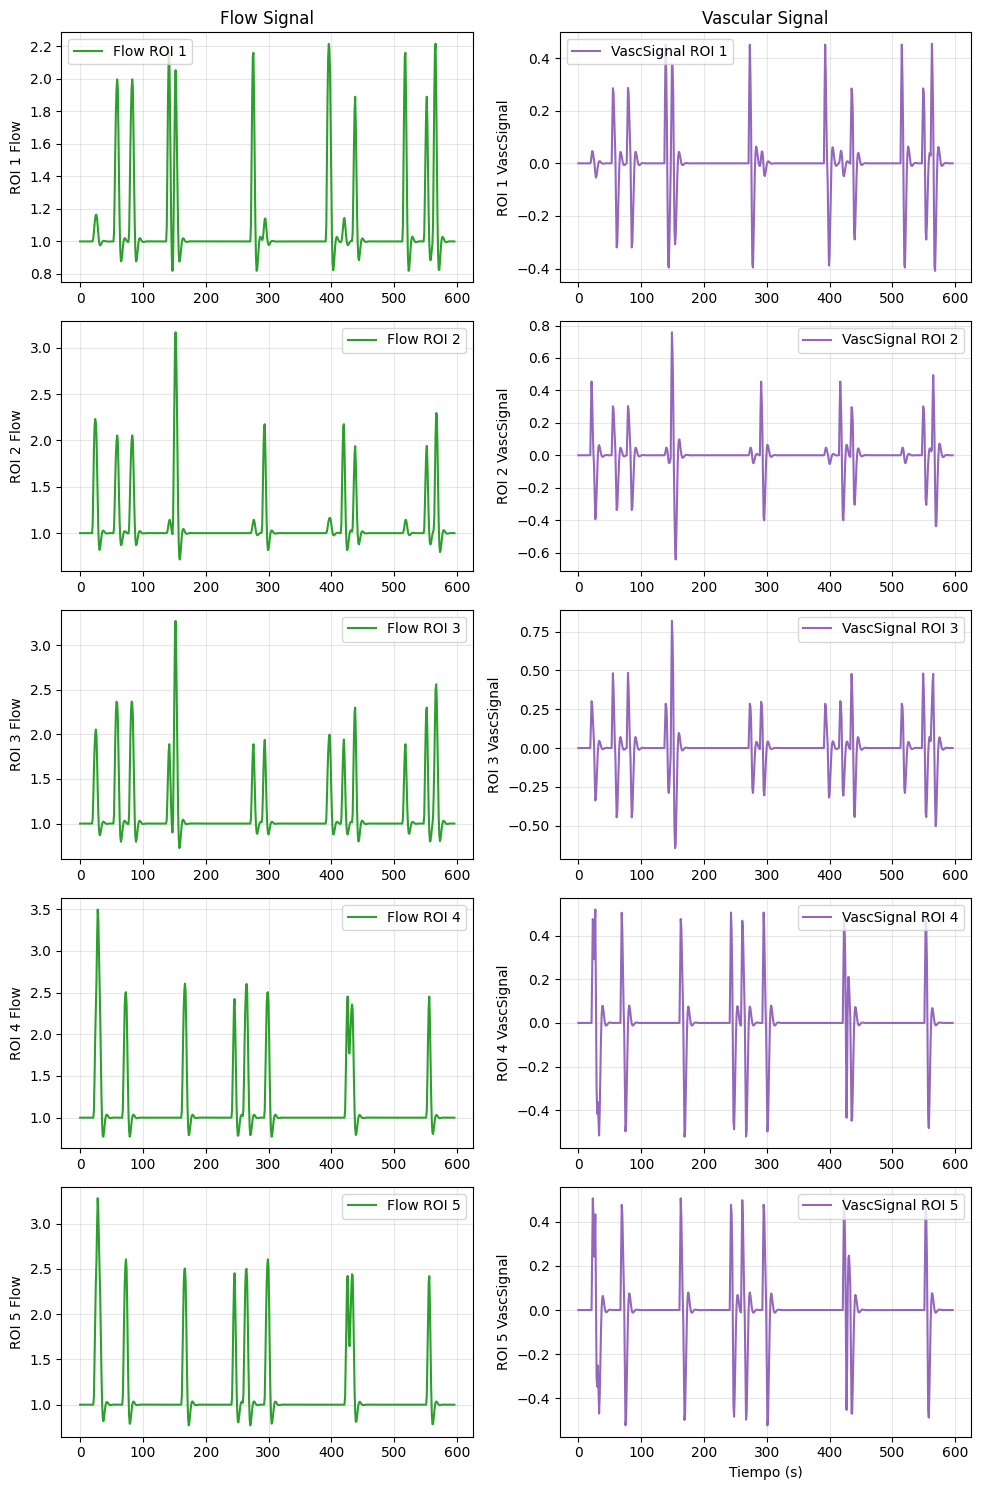

In [117]:
# Simulate flow and vascsignal for each ROI
num_rois = neur.shape[1]
t = []
flow = []
vascsignal = []

for i in range(num_rois):
    t_roi, flow_roi, vascsignal_roi = bmn.NeuraltoFlow(t_neur, neur[:, i])
    t.append(t_roi)
    flow.append(flow_roi)
    vascsignal.append(vascsignal_roi)

#
t = t[0]
flow = np.array(flow).T
vascsignal = np.array(vascsignal).T

#
plt.figure(figsize=(10, num_rois * 3)) # Adjust figure size based on the number of ROIs

for i in range(num_rois):
    plt.subplot(num_rois, 2, 2 * i + 1)
    plt.plot(t, flow[:, i], label=f"Flow ROI {i+1}", color='tab:green', linewidth=1.5)
    plt.ylabel(f"ROI {i+1} Flow")
    plt.grid(alpha=0.3)
    if i == 0:
        plt.title("Flow Signal")
    plt.legend()

    plt.subplot(num_rois, 2, 2 * i + 2)
    plt.plot(t, vascsignal[:, i], label=f"VascSignal ROI {i+1}", color='tab:purple', linewidth=1.5)
    plt.ylabel(f"ROI {i+1} VascSignal")
    plt.grid(alpha=0.3)
    if i == 0:
        plt.title("Vascular Signal")
    if i == num_rois - 1:
        plt.xlabel("Tiempo (s)")
    plt.legend()

plt.tight_layout()
plt.show()

### 1.3 Deoxihemoglobina normalizada, Volumen cerebral sanguíneo y señal BOLD

(598,)
node 1
node 2
node 3
node 4
node 5


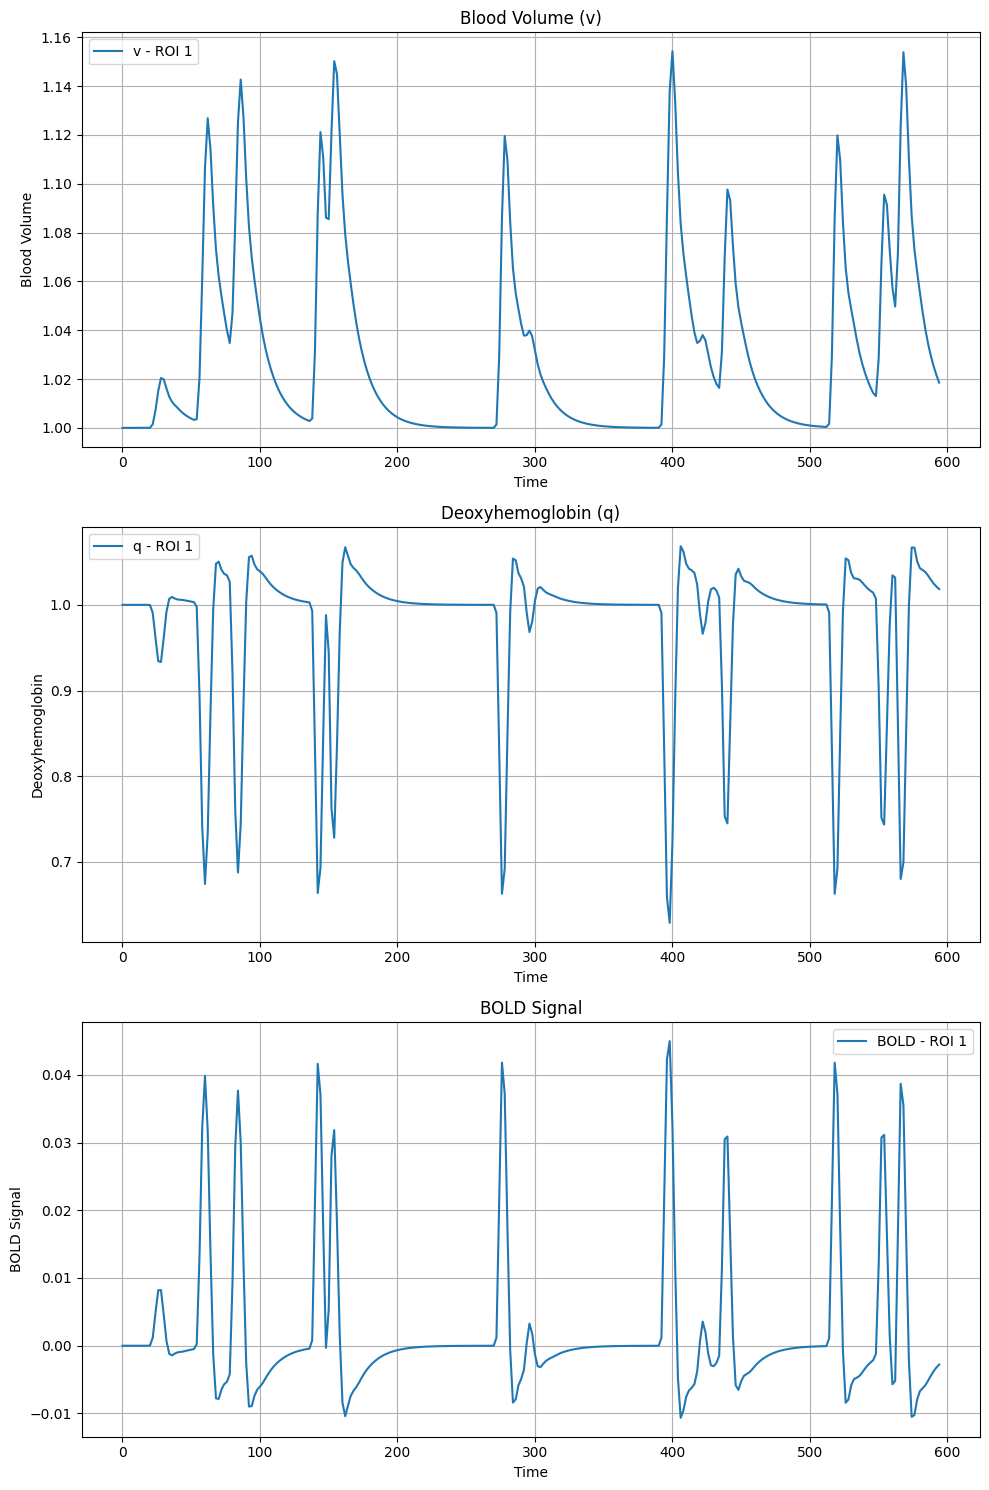

In [118]:
BalloonNetwork = bmn.BalloonNetwork_roiwise(timeline, U, C)
vt = BalloonNetwork['v']
qt = BalloonNetwork['q']
time = BalloonNetwork['tbold'] # bold timeline
Bold_signa = BalloonNetwork['bold']

# ROI to plot
roi_to_plot = 0

plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
plt.plot(time[:, roi_to_plot], vt[:, roi_to_plot], label=f'v - ROI {roi_to_plot + 1}')
plt.xlabel("Time")
plt.ylabel("Blood Volume")
plt.title("Blood Volume (v)")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time[:, roi_to_plot], qt[:, roi_to_plot], label=f'q - ROI {roi_to_plot + 1}')
plt.xlabel("Time")
plt.ylabel("Deoxyhemoglobin")
plt.title("Deoxyhemoglobin (q)")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time[:, roi_to_plot], Bold_signa[:, roi_to_plot], label=f'BOLD - ROI {roi_to_plot + 1}')
plt.xlabel("Time")
plt.ylabel("BOLD Signal")
plt.title("BOLD Signal")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [119]:
print(np.shape(timeline))
print(np.shape(time[:, roi_to_plot]))
print(np.shape(Bold_signa[:,roi_to_plot]))

(300,)
(298,)
(298,)


  # 2 IMPLEMENTACIÓN DE DINÁMICA DE ESTADOS

### 2.1 Funciones para generar estados latentes y para generar el arreglo de estímulos a partir de **estados**

In [120]:
# Same function in BallonModelNet
def gen_node_stimulus(timeline, nblocks=5, duration_range=(1,3)):
    N_pts = len(timeline)
    time_offset = 10
    possible_onsets = np.arange(time_offset, N_pts-time_offset)
    sep_bwn_ons = 10
    durations = []
    onsets = []
    for i in range(nblocks):
        current_block_duration = rn.randint(duration_range[0], duration_range[1])
        current_onset = rn.choice( possible_onsets )
        onsets.append( current_onset )
        durations.append( current_block_duration )
        possible_onsets = possible_onsets[np.logical_or( possible_onsets < current_onset - sep_bwn_ons,
                                                possible_onsets > current_onset + sep_bwn_ons)]
    u = np.zeros(N_pts)
    for i,d in zip(onsets, durations):
        u[i:i+d] = 1
    return u, timeline, onsets, durations

In [121]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Extract tuples of the state and duration
def extract_state_durations(state_array):
    """
    Recibe un arreglo de enteros que representan el estado en cada punto de tiempo.
    Devuelve una lista de tuplas (estado, duración).
    """
    state_array = np.asarray(state_array)

    # Found index where states change
    change_points = np.where(np.diff(state_array) != 0)[0] + 1
    # add start and end to create the segment
    segment_starts = np.r_[0, change_points]
    segment_ends = np.r_[change_points, len(state_array)]

    result = []
    for start, end in zip(segment_starts, segment_ends):
        estado = state_array[start]
        duracion = end - start
        result.append((estado, duracion))

    return result

# Generation of the states array
def gen_state_sequence(timeline, S, duration_range_per_state, seed=None):
    """
    Generates a sequence of states

    Parameters
    ----------
    timeline : array-like (N_pts,)
    S : int Número de estados (0,1,...,S-1).
    duration_range_per_state : list[tuple] one tuple contains the min and maximun duration of the state
    seed : int or None

    Returns
    -------
    states : np.ndarray shape (N_pts,)
    states_dur : list of tuples (state, duration)
    segments : list of dict each dict: {"state": s, "start": i0, "end": i1}
    """
    rng = np.random.default_rng(seed)
    N_pts = len(timeline)
    states = np.zeros(N_pts, dtype=int)
    segments = []

    t_idx = 0
    curr_state = 0
    while t_idx < N_pts:
        dmin, dmax = duration_range_per_state[curr_state]
        dur = int(rng.integers(dmin, dmax+1))
        end = min(t_idx + dur, N_pts)
        states[t_idx:end] = curr_state
        segments.append({"state": curr_state, "start": t_idx, "end": end})
        t_idx = end
        # próxima elección de estado (simple: no repetir el mismo consecutivo)
        if S > 1:
            candidates = [s for s in range(S) if s != curr_state]
            curr_state = int(rng.choice(candidates))
        else:
            curr_state = 0
    states_dur = extract_state_durations(states)

    return states, states_dur, segments

# Extract the active nodes of each state
def active_nodes_per_states(FC_states):
    active_nodes_per_C = []
    for C in FC_states:
        C = C.copy()
        np.fill_diagonal(C, 0)  # dont consider the diagonal
        # Conections ≠ 0
        active_nodes = np.where(np.any(C != 0, axis=0) | np.any(C != 0, axis=1))[0]
        active_nodes_per_C.append(active_nodes.tolist())
    return active_nodes_per_C # List of lists with the active nodes of each state (e.g. [[1, 2, 3, 4], [0, 1, 3, 4], [1, 2, 3, 4]])


# Generates stimulus of a single node
def gen_node_stimulus_by_states(node, states, active_nodes, nblocks_per_state, duration_range_per_state,
                                sep_bwn_ons_per_state, time_offset=10, end_offset=10, seed=None):
    """
    Genera un vector u(t) de 0/1 para *una ROI*, colocando bloques dentro de los segmentos
    de cada estado. Permite configurar n° de bloques, duraciones y separación por estado.

    Parameters
    ----------
    node: int, Corresponding node
    states : (N_pts,) etiquetas [0..S-1]
    active_nodes: list[list] list of active nodes of states
    nblocks_per_state : list[int] largo S
    duration_range_per_state : list[tuple] largo S, en TRs (min,max)
    sep_bwn_ons_per_state : list[int] largo S, separación mínima (en TRs)
    time_offset : int, margen inicial para no empezar pegado a t=0
    end_offset : int, margen final para no terminar pegado a t=T
    seed : int or None

    Returns
    -------
    u : np.ndarray (N_pts,)
    onsets, durations : list of the onsets and durations
    """
    rng = np.random.default_rng(seed)
    N_pts = len(states)
    S = np.max(states) + 1
    u = np.zeros(N_pts, dtype=float)

    onsets_all = []
    durs_all = []

    # For each state, founds the segments
    for s in range(S):
        if node not in active_nodes[s]:
            #print("nodo no activo", node)
            continue
        idx = np.where(states == s)[0]
        if idx.size == 0:
            continue
        # Extraction of contigous segments
        segs = []
        start = idx[0]
        prev = idx[0]
        for k in idx[1:]:
            if k == prev + 1:
                prev = k
            else:
                segs.append((start, prev))# from start to prev correspond to a segment
                start = k
                prev = k
        segs.append((start, prev)) # index, not TR

        # parameters of states
        nblocks = nblocks_per_state[s]
        dmin, dmax = duration_range_per_state[s]
        sep = sep_bwn_ons_per_state[s]


        possible_positions = []
        for (a, b) in segs:
            a2 = max(a, time_offset) # posible positions starts after the offset
            b2 = min(b, N_pts - end_offset) # posible positions ends before the offset
            if a2 <= b2:
                possible_positions.append(list(range(a2, b2+1)))# list of posible position of segments

        #possible_positions = np.array(possible_positions, dtype=int)
        onsets_s = []
        durs_s = []
        # It generates only one stimulus in each segment of "s" state
        for positions_segm in possible_positions:
            if len(positions_segm) == 0:
                break
            onset = int(rng.choice(np.array(positions_segm)))
            dur = int(rng.integers(dmin, dmax+1))
            end = min(onset + dur, N_pts)
            # on the block
            u[onset:end] = 1.0
            onsets_s.append(onset)
            durs_s.append(dur)

            #mask_keep = (possible_positions < (onset - sep)) | (possible_positions > (end + sep))
            #possible_positions = possible_positions[mask_keep]

        onsets_all.extend(onsets_s)
        durs_all.extend(durs_s)
        #print(onsets_all)

    if len(onsets_all) == 0:# In case the node didnt activate with any state, the stimulus will be spontaneous
        dmin, dmax = duration_range_per_state[s]
        u,_ ,onsets_all, durs_all = gen_node_stimulus(states, nblocks=5, duration_range=(dmin, dmax))


    return u, onsets_all, durs_all


# Network of stimulus
def gen_network_stimulus_by_states(timeline, states, N_nds, FC_states,
                                   nblocks_per_state, duration_range_per_state,
                                   sep_bwn_ons_per_state, time_offset=10, end_offset=10, seed=None):
    """
    Generates U(t) (N_pts x N_nds) align with the states sequence

    Parameters
    ----------
    timeline : (N_pts,)
    states   : (N_pts,) states labels
    N_nds    : int, number of ROIs
    FC_states : list[np.ndarray (N_nds, N_nds)] len S, a list of connectivity matrices
    nblocks_per_state : list[int] len(S)
    duration_range_per_state : list[tuple] len(S)
    sep_bwn_ons_per_state : list[int] len(S)
    time_offset : int
    end_offset : int
    seed : int or None

    Returns
    -------
    U : np.ndarray (N_pts, N_nds)
    meta : list[dict]
    """
    rng = np.random.default_rng(seed)
    N_pts = len(timeline)
    U = np.zeros((N_pts, N_nds), dtype=float)
    meta = []
    active_nodes_per_C = active_nodes_per_states(FC_states)

    for node in range(N_nds):
        # Changes the seed for each ROI
        seed_n = None if seed is None else int(rng.integers(0, 1_000_000))
        u_n, on_n, du_n = gen_node_stimulus_by_states(
            node = node,
            states=states,
            active_nodes=active_nodes_per_C, # The active nodes of each state
            nblocks_per_state=nblocks_per_state,
            duration_range_per_state=duration_range_per_state,
            sep_bwn_ons_per_state=sep_bwn_ons_per_state,
            time_offset=time_offset,
            end_offset=end_offset,
            seed=seed_n
        )
        U[:, node] = u_n
        meta.append({"roi": node, "onsets": on_n, "durations": du_n})
    return U, meta


### 2.2 Funciones para reemplazar neurq y stimulusToNeural

In [122]:
import numpy as np
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import numpy as np

def StimulusToNeural_piecewise(timing, u, const, C_list, state_array, segm_dur,TR):
    """
    Stimulus-to-neural function with piecewise-static connectivity.

    Parameters
    ----------
    timing : array-like Original time points of the stimulus
    u : array (Nsamples, Nrois) Stimulus input
    const : float Gain factor for stimulus
    C_list : list of np.ndarray List of connectivity matrices
    state_array : array-like (len = number of timepoints after interpolation)
        Sequence of state indices, one per timepoint (e.g. [0,0,0,1,1,2,...])
    segm_dur: array-like, duration of each state
    Returns
    -------
    t_all : array Concatenated time array
    neur_all : array Neural responses concatenated across blocks
    """

    Nsamples, Nrois = u.shape
    kappa1 = 2
    tau = 2
    N0 = 0
    newdeltat = 1

    newtiming = np.arange(min(timing), max(timing), newdeltat)
    #print(newtiming)
    # Interpolación de estímulo
    if u.ndim == 1:
        u = u[:, np.newaxis]

    newu_list = []
    for j in range(u.shape[1]):
        f_interp = interp1d(timing, u[:, j], kind='nearest')
        newu = f_interp(newtiming)
        newu_list.append(newu[:, np.newaxis] * const)
    newu = np.concatenate(newu_list, axis=1)

    interpolators = [interp1d(newtiming, newu[:, j], kind='nearest') for j in range(u.shape[1])]

    A = (1/tau) * np.eye(Nrois)
    I0 = - N0

    # Dynamic part
    I_concat = []
    t_concat = []
    I_last = Nrois * [I0]

    start = 0
    for segm in segm_dur:
        end = start + int(segm[1]*TR) # star + duration of the block
        t_seg = newtiming[start:end]
        # print(t_seg)
        C = C_list[segm[0]]  # elegir la conectividad correspondiente
        params = [kappa1, tau, N0, interpolators, A, C]
        sol = solve_ivp(neureq, [t_seg[0], t_seg[-1]], I_last, args=(params,), t_eval=t_seg, max_step=np.diff(t_seg).min()/4)
        I_concat.append(sol.y.T)
        t_concat.append(sol.t)
        I_last = sol.y[:, -1]  # Initial condition for the next block
        start = end

    I = np.vstack(I_concat)
    t_all = np.concatenate(t_concat)

    newstim = np.concatenate([f(t_all)[:, np.newaxis] for f in interpolators], axis=1)
    neur = newstim - I
    neur[neur < 0] = 0

    return t_all, neur

# Same function neureq in BalloonModelNet.py
def neureq(t, I, params): # Eq14 Buxton
    kappa1, tau, N0, interpolators, A, C = params
    ut = np.array([f(t) for f in interpolators])
    N = ut - C @ I
    # N = ut - I
    if np.any(N > -N0):
        dIdt = (kappa1/tau) * N - A@I
    else:
        dIdt = (-kappa1/tau) * N0 - A@I # neural response cannot go below 0
    return dIdt

### 2.3 Generación de nodos

In [123]:
# timeline
TR = 2.0
T  = 300
timeline = np.arange(0, T*TR, TR)     # N_pts = T
D = 5
S = 3

#
FC_states = gen_states_A(S, D, N_conns=[2,1,3], sym=True, seed=40)
duration_range_states = [(20,40), (15,30), (25,50)]

sample, states_dur, segments = gen_state_sequence(timeline, S=S, duration_range_per_state=duration_range_states, seed=123)

nblocks_per_state        = [3, 6, 4]          #
duration_range_per_state = [(3,5), (1,3), (2,4)]  #
sep_bwn_ons_per_state    = [6, 4, 5]          #

# generates the stimulus matrix of nodes

U, meta = gen_network_stimulus_by_states(timeline = timeline, states=sample, N_nds=D,
                                         FC_states = FC_states,
                                         nblocks_per_state=nblocks_per_state,
                                         duration_range_per_state = duration_range_per_state,
                                         sep_bwn_ons_per_state=sep_bwn_ons_per_state,
                                         time_offset=10,
                                         end_offset=10,
                                         seed=7)

# Dynamic states in the product C * u
u_list = []
for C in FC_states:
  u = np.transpose(C @ U.T)
  u_list.append(u)
u_blocks = np.zeros_like(U)
idx_state0 = np.where(sample == 0)[0]
idx_state1 = np.where(sample == 1)[0]
idx_state2 = np.where(sample == 2)[0]
u_blocks[idx_state0,:] = u_list[0][idx_state0,:]
u_blocks[idx_state1,:] = u_list[1][idx_state1,:]
u_blocks[idx_state2,:] = u_list[2][idx_state2,:]


deltat = 1
const = 1

BalloonNetwork = {'timing': timeline, 'u': u_blocks,
                  'tneur':[], 'neur':[], 'tflowin':[], 'flowin':[],
                  'vascsignal':[], 'tbold': [], 'bold':[], 'v':[], 'q':[]}

tneur, neur = StimulusToNeural_piecewise(timing=timeline, u = u_blocks, const=const, C_list = FC_states , state_array= sample, segm_dur = states_dur, TR= TR) # stimulus to neural response
BalloonNetwork['tneur'] = tneur
BalloonNetwork['neur'] = neur
BalloonNetwork['tu'] = timeline
BalloonNetwork['u'] = u_blocks

TE = 0.03
Nsamples, Nrois = neur.shape

for inode in range(Nrois):
  print(f'node {inode+1}')
  tflowin, flowin, vascsignal = bmn.NeuraltoFlow(tneur, neur[:, inode]) # neural to flow in
  tbold, bold, q, v = bmn.BalloonModel(tflowin, flowin, TE) # flow in to BOLD
  BalloonNetwork['tflowin'].append(tflowin[:,np.newaxis])
  BalloonNetwork['flowin'].append(flowin[:,np.newaxis])
  BalloonNetwork['vascsignal'].append(vascsignal[:,np.newaxis])
  BalloonNetwork['tbold'].append(tbold[:,np.newaxis])
  BalloonNetwork['bold'].append(bold[:,np.newaxis])
  BalloonNetwork['v'].append(v[:,np.newaxis])
  BalloonNetwork['q'].append(q[:,np.newaxis])

for k in BalloonNetwork:
  vl = BalloonNetwork[k]
  if isinstance(vl, list):
    vl = np.concatenate(vl, axis=1)
    BalloonNetwork[k] = vl


node 1
node 2
node 3
node 4
node 5


### 2.4 Visualización de estados en la actividad neuronal

In [124]:
import numpy as np
import matplotlib
from matplotlib.patches import Patch

def _compute_edges(t):
    #Compute the edges of the states in x
    mid = (t[:-1] + t[1:]) / 2.0
    left0  = t[0] - (mid[0] - t[0])
    rightN = t[-1] + (t[-1] - mid[-1])
    return np.concatenate(([left0], mid, [rightN]))

def shade_states(ax, timeline, sample, cmap, alpha=0.18, zorder=0):
    """
    Sombrea el fondo del eje 'ax' según 'sample' (estados) a lo largo de 'timeline'.
    - timeline: 1D, same dimensions of sample
    - sample:   1D, state series (ex. (1,1,1,0,0,0,2,2,2,1,1,1,0,0,0))
    - cmap:     colormap of the states
    """
    t_edges  = _compute_edges(timeline)
    states   = np.unique(sample)
    idx_of   = {s:i for i, s in enumerate(states)}

    start = 0
    curr  = sample[0]
    for k in range(1, len(sample)+1):
        if k == len(sample) or sample[k] != curr:
            left, right = t_edges[start], t_edges[k]
            color = cmap(idx_of[curr])
            ax.axvspan(left, right, facecolor=color, alpha=alpha, linewidth=0, zorder=zorder)
            if k < len(sample):
                start, curr = k, sample[k]

def plot_signal_states(timeline, tsignal, signal, D, S, FC_states, sample, TR=2, alpha=0.18, zorder=0, U=None, mode = "neur"):
    if mode == "neur":
        title = "Neural response of ROIs"
    elif mode == "bold":
        title = "Bold signal of ROIs"
    cmap = matplotlib.colormaps.get_cmap('viridis').resampled(S)
    Nrois=D
    mid = (timeline[:-1] + timeline[1:]) / 2.0
    t_edges = np.concatenate(([timeline[0] - (mid[0] - timeline[0])], mid, [timeline[-1] + (timeline[-1] - mid[-1])]))
    # Adjust figure size based on the number of ROIs and the added sample plot
    fig, axes = plt.subplots(Nrois + 1, 1, figsize=(10, Nrois * 2 + 2), gridspec_kw={'height_ratios': [2] * Nrois + [1]})
    for i in range(Nrois):
        ax = axes[i]
        shade_states(ax, timeline, sample, cmap, alpha=0.18, zorder=0)
        #ax.plot(timeline, u_blocks[:, i], label=f"Estímulo ROI {i+1}", color='tab:blue', linewidth=1.5, linestyle='--')
        if U is not None:
            ax.plot(timeline, U[:, i], label=f"Estímulo ROI {i+1}", color='tab:blue', linewidth=1.5, linestyle='--')

        ax.plot(tsignal, signal[:, i], label=f"Respuesta Neural ROI {i+1}", color='tab:red', linewidth=1.5)
        ax.set_ylabel(f"ROI {i+1} Amplitud")
        ax.grid(alpha=0.3)
        ax.set_xlim(0, len(timeline)*TR)  #
        if i == 0:
            ax.set_title(title)
        if i == Nrois - 1:
            ax.set_xlabel("Tiempo (s)")
        ax.legend()
    ax_sample = axes[-1]

    states = np.unique(sample)
    cmap = matplotlib.colormaps.get_cmap('viridis').resampled(S)

    # Horizontal bar of the states
    pc = ax_sample.pcolormesh(t_edges,           # x borders
                              [0, 1],
                              sample.reshape(1, -1),
                              cmap=cmap,
                              shading="flat"
                              )

    ax_sample.set_title('States over time')
    ax_sample.set_xlabel('Time (s)')
    ax_sample.set_yticks([])
    #ax_sample.set_xlim(timeline[0], timeline[-1])
    plt.tight_layout()
    fig.colorbar(pc, ax=ax_sample, ticks=states, label='State')
    plt.show()


    # Figure 2 C matrices
    fig2, axes2 = plt.subplots(1, S, figsize=(6*S, 5)) # Dynamically set figure size based on S

    # Plot each C from FC_states using a loop
    if S > 1: # Check if there are multiple states to plot in separate subplots
        for i in range(S):
            sns.heatmap(FC_states[i], ax=axes2[i], cmap="viridis", annot=True, fmt=".2f")
            axes2[i].set_title(f"Connectivity matrix - State {i}")
            axes2[i].set_xlabel('ROI')
            axes2[i].set_ylabel('ROI')
    else: # If there's only one state, plot it in the single subplot
        sns.heatmap(FC_states[0], ax=axes2, cmap="viridis", annot=True, fmt=".2f")
        axes2.set_title("Connectivity matrix - State 0")
        axes2.set_xlabel('ROI')
        axes2.set_ylabel('ROI')


    plt.tight_layout()
    plt.show()

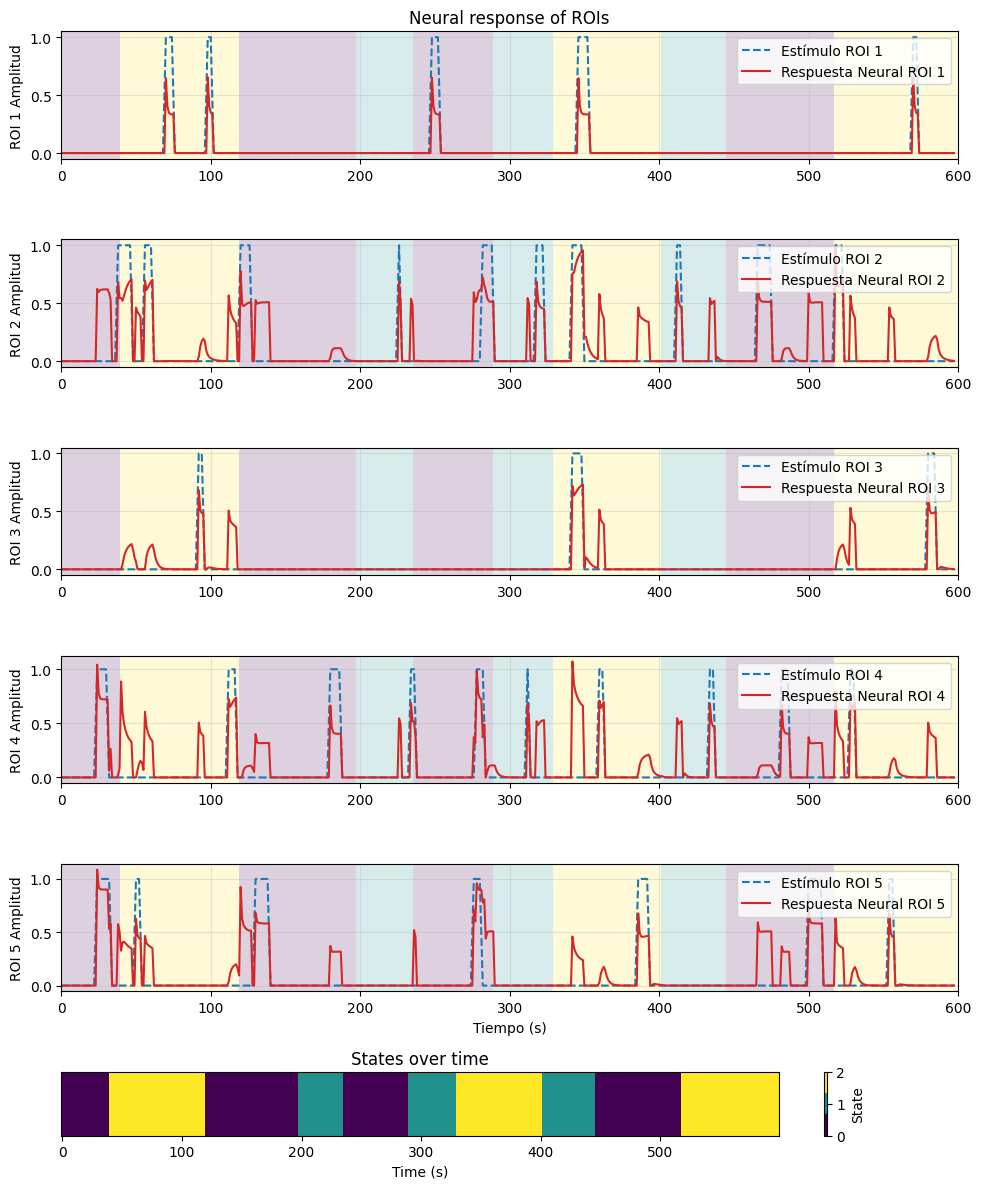

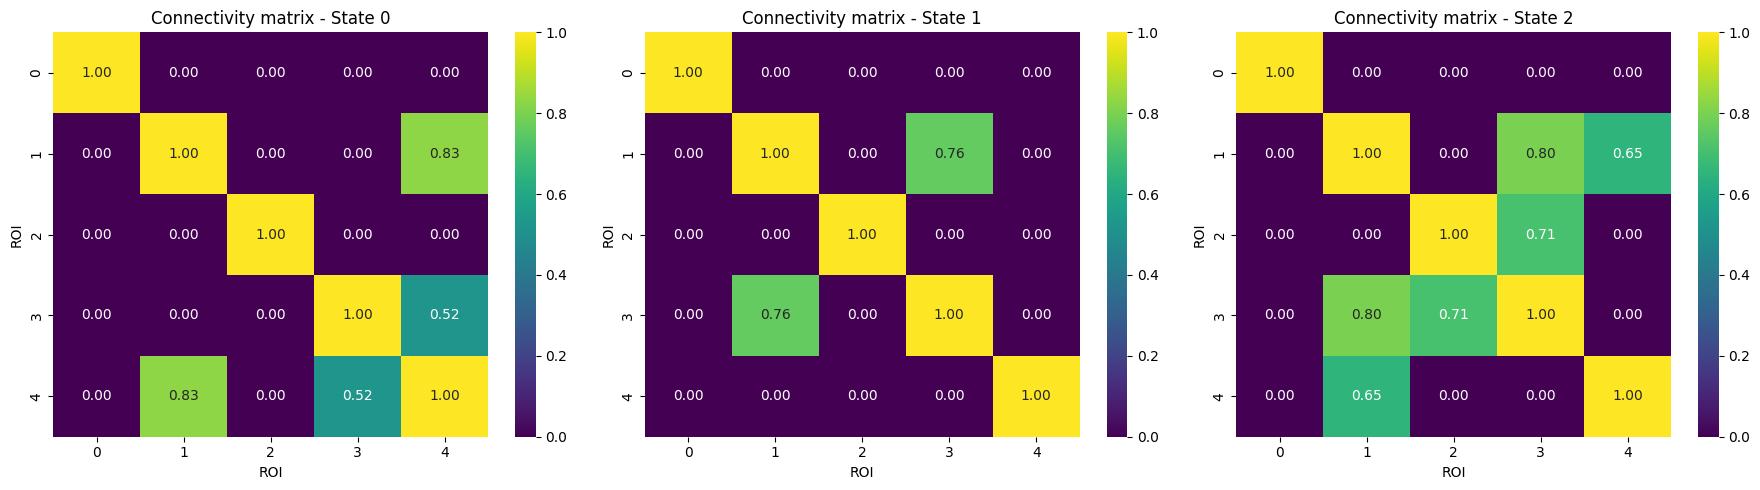

In [125]:
plot_signal_states(timeline, tneur, neur, D, S, FC_states, sample, alpha=0.18, zorder=0, U=U)

### 2.5 Visualizacion de estados en señal Bold

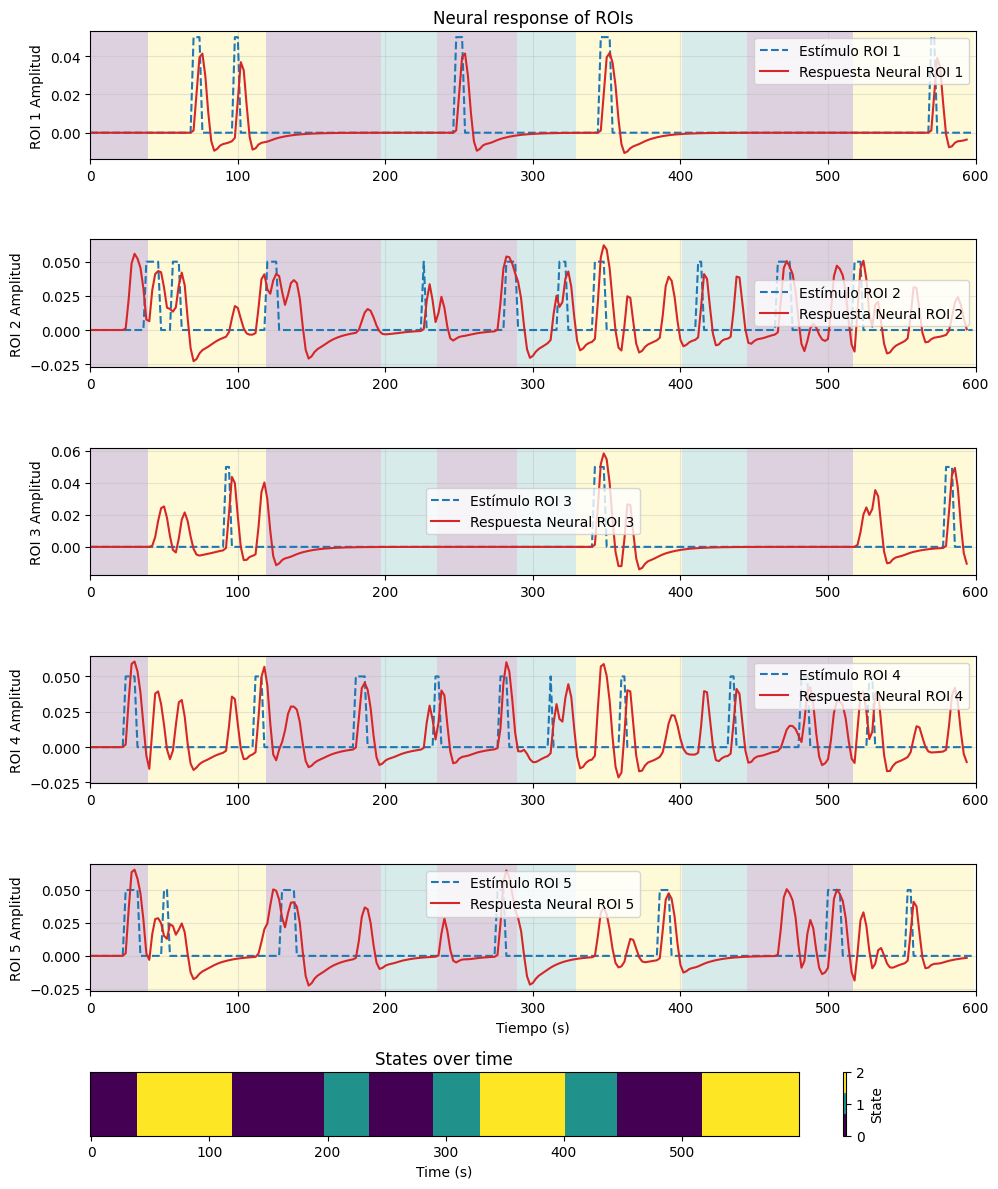

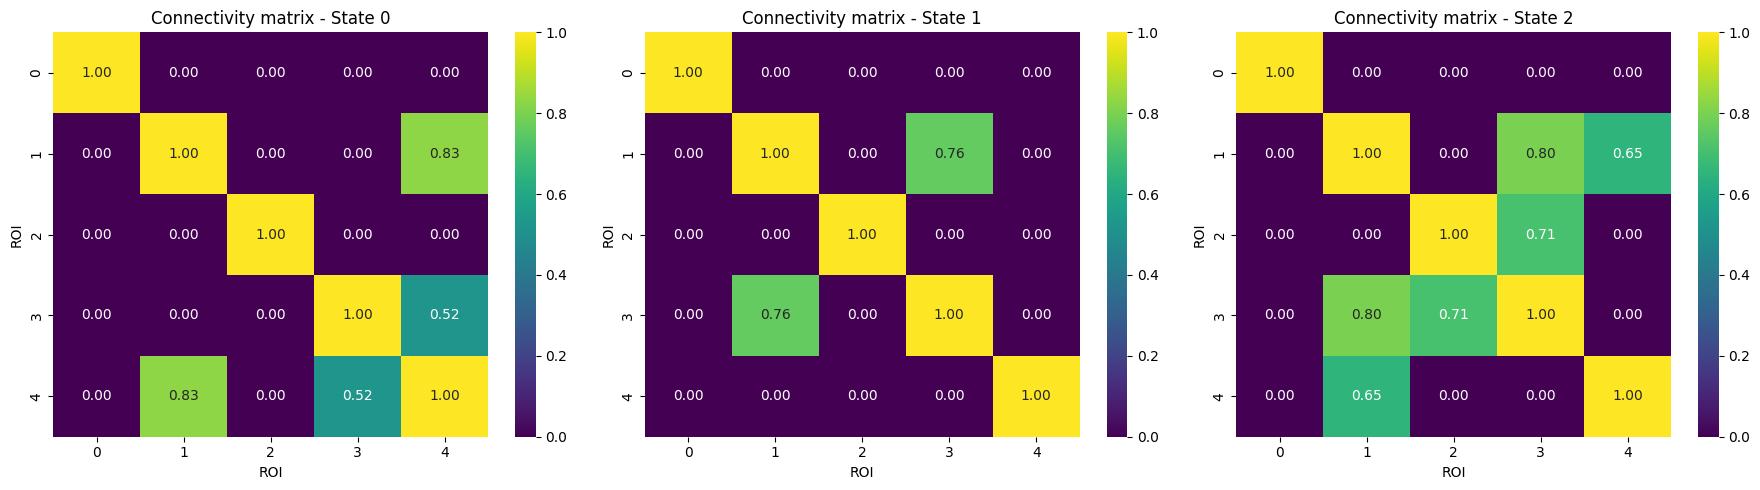

In [126]:
tbold = BalloonNetwork['tbold'][:,0]
bold = BalloonNetwork['bold']
plot_signal_states(timeline, tbold, bold, D, S, FC_states, sample, alpha=0.15, zorder=0, U=U*0.05)


### 2.6 Comprobar la generación de estados

In [127]:
def concatenate_bold_by_state(bold_signal, states_array, state_index):
    """
    extract the segments of BOLD signal of one state

    Parameters
    ----------
    bold_signal : np.ndarray (N_pts, N_rois)
    states_array : np.ndarray (N_pts,) the states sequence
    state_index : int the index of the state to extract

    Returns
    -------
    concatenated_bold : np.ndarray (N_selected_pts, N_rois)
    """
    # Find the indices where the state is the desired one
    indices_of_state = np.where(states_array == state_index)[0]

    # Select the corresponding rows from the bold signal
    concatenated_bold = bold_signal[indices_of_state, :]

    return concatenated_bold

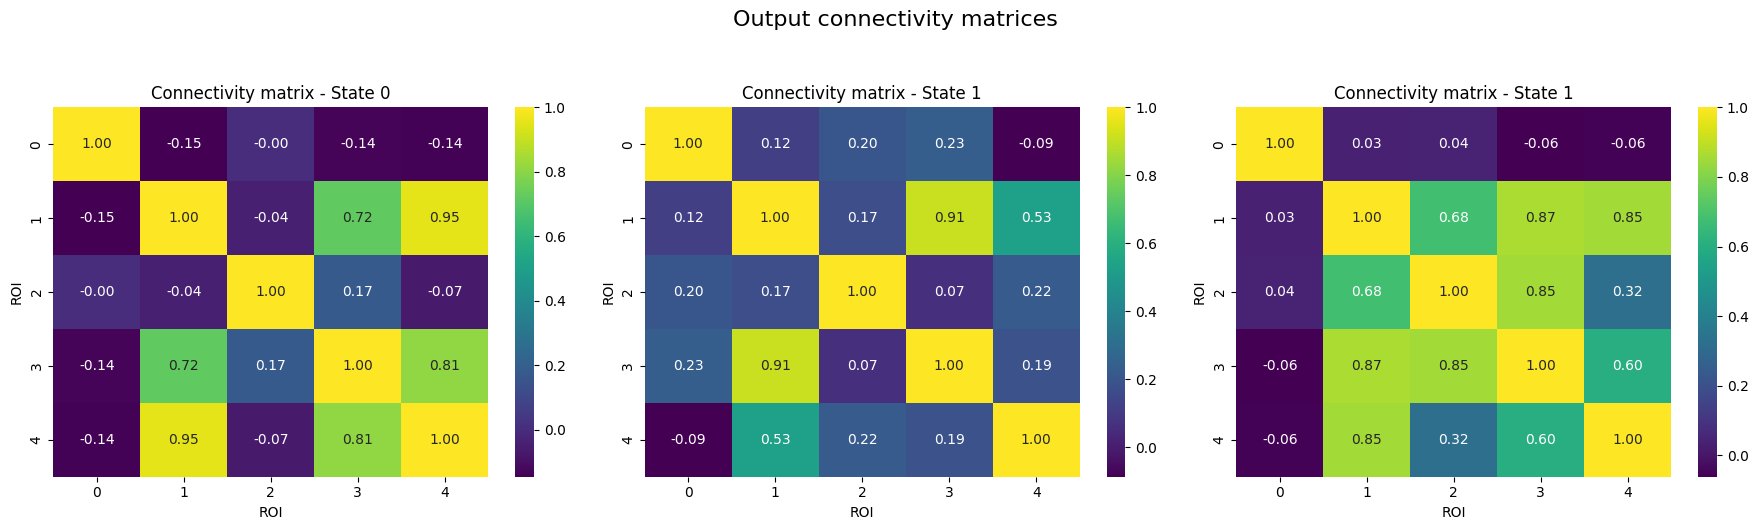

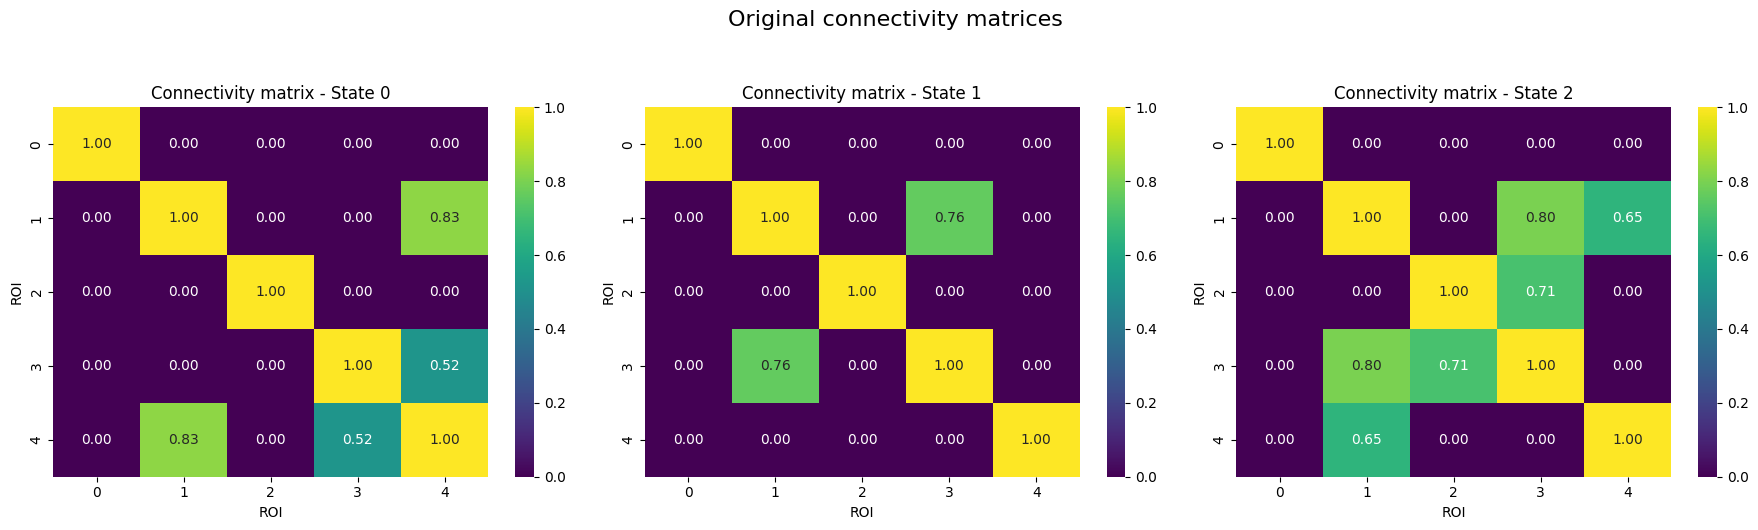

In [128]:
sample = sample[0:np.shape(bold)[0]]
bold_state0 = concatenate_bold_by_state(bold, sample, 0)
bold_state1 = concatenate_bold_by_state(bold, sample, 1)
bold_state2 = concatenate_bold_by_state(bold, sample, 2)

# Calculate the correlation matrix for each state
corr_matrix_state0 = np.corrcoef(bold_state0.T)
corr_matrix_state1 = np.corrcoef(bold_state1.T)
corr_matrix_state2 = np.corrcoef(bold_state2.T)

fig1, axes2 = plt.subplots(1, S, figsize=(18, 5)) # Dynamically set figure size based on S

sns.heatmap(corr_matrix_state0, ax=axes2[0], cmap="viridis", annot=True, fmt=".2f")
axes2[0].set_title(f"Connectivity matrix - State 0")
axes2[0].set_xlabel('ROI')
axes2[0].set_ylabel('ROI')

sns.heatmap(corr_matrix_state1, ax=axes2[1], cmap="viridis", annot=True, fmt=".2f")
axes2[1].set_title(f"Connectivity matrix - State 1")
axes2[1].set_xlabel('ROI')
axes2[1].set_ylabel('ROI')

sns.heatmap(corr_matrix_state2, ax=axes2[2], cmap="viridis", annot=True, fmt=".2f")
axes2[2].set_title(f"Connectivity matrix - State 1")
axes2[2].set_xlabel('ROI')
axes2[2].set_ylabel('ROI')
fig1.suptitle("Output connectivity matrices", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


fig2, axes2 = plt.subplots(1, S, figsize=(6*S, 5)) # Dynamically set figure size based on S
for i in range(S):
    sns.heatmap(FC_states[i], ax=axes2[i], cmap="viridis", annot=True, fmt=".2f")
    axes2[i].set_title(f"Connectivity matrix - State {i}")
    axes2[i].set_xlabel('ROI')
    axes2[i].set_ylabel('ROI')
fig2.suptitle("Original connectivity matrices", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

### BONUS: Visualización de U * C

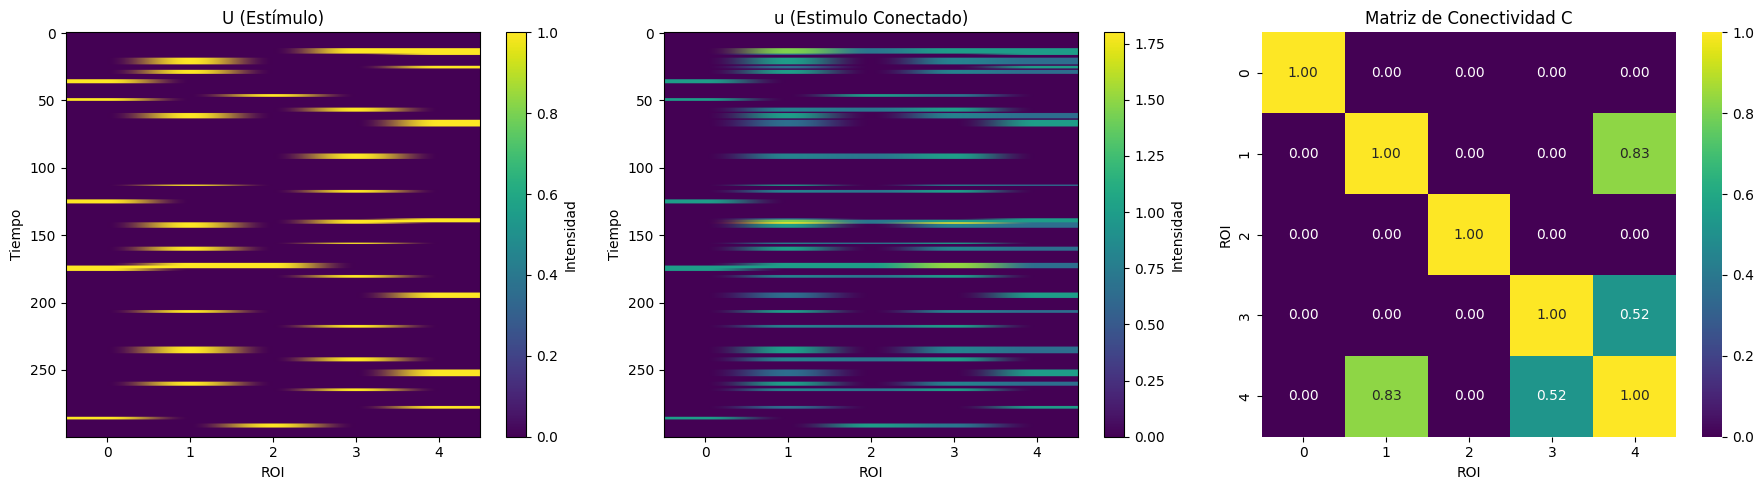

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
from scipy.interpolate import interp1d
import sys
import seaborn as sns

# Plotting U, u, and C with colormap
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im_u = axes[0].imshow(U, aspect='auto', cmap='viridis')
axes[0].set_title('U (Estímulo)')
axes[0].set_xlabel('ROI')
axes[0].set_ylabel('Tiempo')
fig.colorbar(im_u, ax=axes[0], label='Intensidad')

im_v = axes[1].imshow(u, aspect='auto', cmap='viridis')
axes[1].set_title('u (Estimulo Conectado)')
axes[1].set_xlabel('ROI')
axes[1].set_ylabel('Tiempo')
fig.colorbar(im_v, ax=axes[1], label='Intensidad')

sns.heatmap(FC_states[0], ax=axes[2], cmap="viridis", annot=True, fmt=".2f")
axes[2].set_title("Matriz de Conectividad C")
axes[2].set_xlabel('ROI')
axes[2].set_ylabel('ROI')


plt.tight_layout()
plt.show()

In [130]:
u_list = []
for C in FC_states:
  u = np.transpose(C @ U.T)
  u_list.append(u)
u_blocks = np.zeros_like(U)
idx_state0 = np.where(sample == 0)[0]
idx_state1 = np.where(sample == 1)[0]
idx_state2 = np.where(sample == 2)[0]
u_blocks[idx_state0,:] = u_list[0][idx_state0,:]
u_blocks[idx_state1,:] = u_list[1][idx_state1,:]
u_blocks[idx_state2,:] = u_list[2][idx_state2,:]

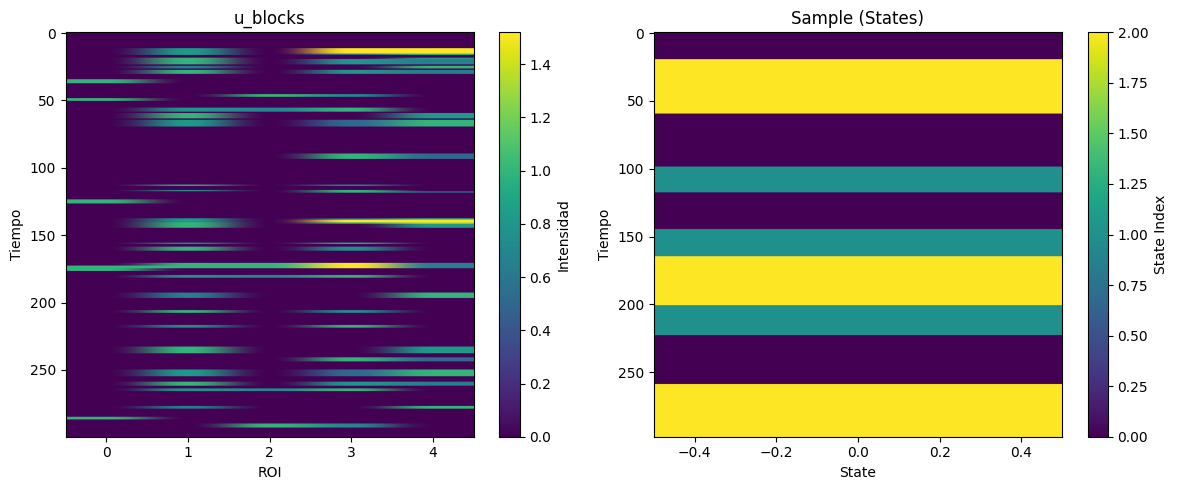

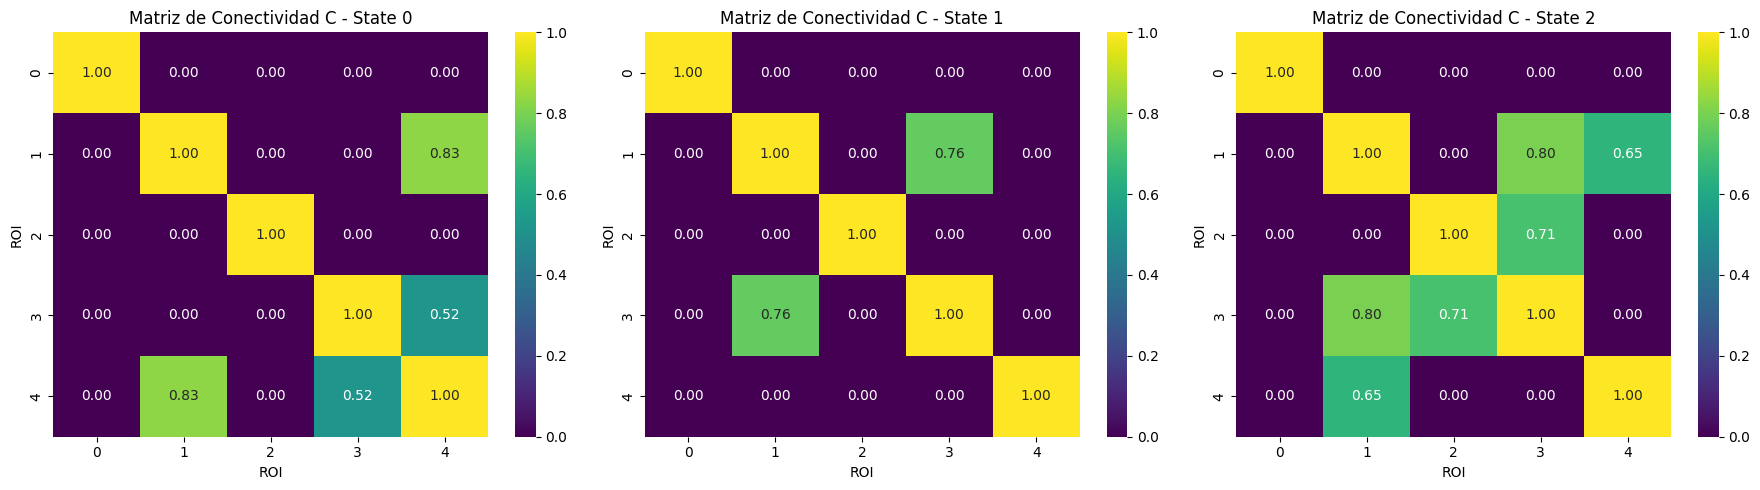

In [131]:
# Create two separate figures: one for the top row, one for the bottom row

# Figure 1: u_blocks and sample
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))

# Plot u_blocks
im_u_blocks = axes1[0].imshow(u_blocks, aspect='auto', cmap='viridis')
axes1[0].set_title('u_blocks')
axes1[0].set_xlabel('ROI')
axes1[0].set_ylabel('Tiempo')
fig1.colorbar(im_u_blocks, ax=axes1[0], label='Intensidad')

# Plot sample as a column
im_sample = axes1[1].imshow(sample.reshape(-1, 1), aspect='auto', cmap='viridis')
axes1[1].set_title('Sample (States)')
axes1[1].set_xlabel('State')
axes1[1].set_ylabel('Tiempo')
# Set y-ticks to match the time steps
axes1[1].set_yticks(np.arange(0, len(sample), 50)) # Adjust tick frequency as needed
axes1[1].set_yticklabels(np.arange(0, len(sample), 50))
fig1.colorbar(im_sample, ax=axes1[1], label='State Index')

plt.tight_layout()
plt.show()


# Figure 2: C matrices
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))

# Plot each C from FC_states
sns.heatmap(FC_states[0], ax=axes2[0], cmap="viridis", annot=True, fmt=".2f")
axes2[0].set_title("Matriz de Conectividad C - State 0")
axes2[0].set_xlabel('ROI')
axes2[0].set_ylabel('ROI')

sns.heatmap(FC_states[1], ax=axes2[1], cmap="viridis", annot=True, fmt=".2f")
axes2[1].set_title("Matriz de Conectividad C - State 1")
axes2[1].set_xlabel('ROI')
axes2[1].set_ylabel('ROI')

sns.heatmap(FC_states[2], ax=axes2[2], cmap="viridis", annot=True, fmt=".2f")
axes2[2].set_title("Matriz de Conectividad C - State 2")
axes2[2].set_xlabel('ROI')
axes2[2].set_ylabel('ROI')


plt.tight_layout()
plt.show()

# Copia de seguridad

In [132]:
def gen_node_stimulus_by_states(node, states, nblocks_per_state, duration_range_per_state,
                                sep_bwn_ons_per_state, time_offset=10, seed=None):
    """
    Genera un vector u(t) de 0/1 para *una ROI*, colocando bloques dentro de los segmentos
    de cada estado. Permite configurar n° de bloques, duraciones y separación por estado.

    Parameters
    ----------
    node: int, Corresponding node
    states : (N_pts,) etiquetas [0..S-1]
    nblocks_per_state : list[int] largo S
    duration_range_per_state : list[tuple] largo S, en TRs (min,max)
    sep_bwn_ons_per_state : list[int] largo S, separación mínima (en TRs)
    time_offset : int, margen inicial para no empezar pegado a t=0
    seed : int or None

    Returns
    -------
    u : np.ndarray (N_pts,) con 0/1
    onsets, durations : listas con los onsets y duraciones elegidos
    """
    rng = np.random.default_rng(seed)
    N_pts = len(states)
    S = np.max(states) + 1
    u = np.zeros(N_pts, dtype=float)

    onsets_all = []
    durs_all = []

    # para cada estado, buscamos sus segmentos
    for s in range(S):
        idx = np.where(states == s)[0]
        if idx.size == 0:
            continue
        # Extraction of contigous segments
        segs = []
        start = idx[0]
        prev = idx[0]
        for k in idx[1:]:
            if k == prev + 1:
                prev = k
            else:
                segs.append((start, prev))# from start to prev correspond to a segment
                start = k
                prev = k
        segs.append((start, prev)) # index, not TR
        print(segs)

        # parameters of states
        nblocks = nblocks_per_state[s]
        dmin, dmax = duration_range_per_state[s]
        sep = sep_bwn_ons_per_state[s]

        # espacio disponible (por segmentos)
        # iremos colocando onsets en índices permitidos dentro de cada seg
        possible_positions = []
        for (a, b) in segs:
            a2 = max(a, time_offset) # posible positions starts after the offset
            if a2 <= b:
                possible_positions.extend(list(range(a2, b+1)))

        possible_positions = np.array(possible_positions, dtype=int)
        # para evitar colisiones por separación mínima usamos un procedimiento greedy
        onsets_s = []
        durs_s = []
        for _ in range(nblocks):
            if possible_positions.size == 0:
                break
            onset = int(rng.choice(possible_positions))
            dur = int(rng.integers(dmin, dmax+1))
            end = min(onset + dur, N_pts)
            # pinta el bloque
            u[onset:end] = 1.0
            onsets_s.append(onset)
            durs_s.append(dur)
            # aplica ventana de exclusión por separación
            mask_keep = (possible_positions < (onset - sep)) | (possible_positions > (end + sep))
            possible_positions = possible_positions[mask_keep]

        onsets_all.extend(onsets_s)
        durs_all.extend(durs_s)

    return u, onsets_all, durs_all